# Word Completion using Seq2Seq(Encoder-Decoder) Model


This is a implementation of seq2seq Model for next word prediction using Teacher-Forcing Architecture.

<b>Teacher Forcing</b> is a method of training Recurrent neural network models that use the ground truth from a prior time step as input.

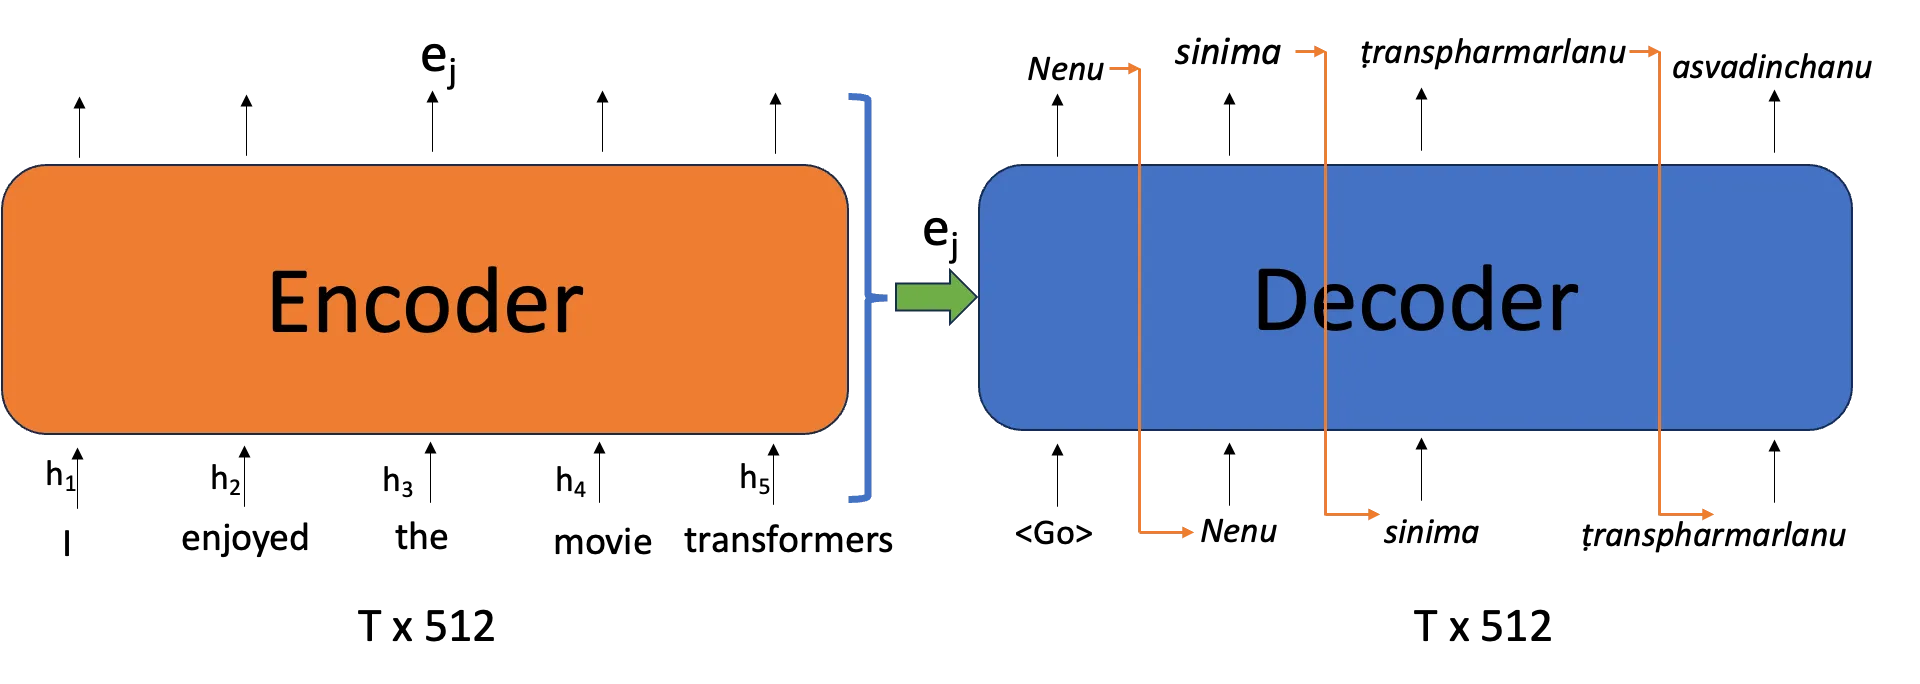

<br><center> The output of decoder is fed into next decoder step.


To Generate the text we will be using two types of search.
1. Greedy Search
2. Beam Search

#### Greedy Search
As the name suggests <b>Greedy Search</b>, it is selecting the token of highest probablity from vocabulary V.

<center>y<sub>t</sub> = argmax<sub>y in V</sub> P(y | y<sub>1</sub>,y<sub>2</sub>....,y<sub>n</sub>)</center><br>
Example, <br>Considered we have vocabulary fo 16 words including <code>OOV</code>`(out of vocabulary).
The final token is selected based upon the highest condational probablity of all the tokens in <code>V</code>, then for second set it will take selected token and then it will serch for next token based upon privously selected token. And cycle continues till the <b>max_length</b>

The Main Drawback of Greedy Search Algorithm is it dose not consider posterior tokens for higher condational probablites.
#### Beam Search.

It is improved version of Beam Search Algorithm. Beam Search uses a parameter called beam_size , that is count of tokens with highest probablites at each time step t. 

### Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import tensorflow as tf
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gc
import warnings
warnings.filterwarnings("ignore")
import math


print(tf.__version__)
print(tf.config.list_physical_devices())
print(gc.collect())



2024-03-13 10:29:40.828628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 10:29:41.160330: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 10:29:41.161593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 10:29:42.554288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
4


2024-03-13 10:29:47.549774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Preprocessing

Data is extracted is from Cornell Movie dataset, Punctuations are removed and contracations are converted to word that they represent such as <br>
- aren't → are not.
- couldn't → could not.



In [14]:
data = [x.strip() for x in open("../data/Eron_genral.txt",encoding='utf-8').readlines()]

In [19]:
vocabulary_sent = []
prefix = '<start> '
sufix = ' <end>'
pairs = []

for line in data:
    line = line.split()
    inp = f"{prefix}{' '.join(line[:-1])}{sufix}"
    op = f"{prefix}{line[-1]}{sufix}"
    pairs.append((inp,op))
    sent = f"{prefix}{' '.join(line)}{sufix}"
    vocabulary_sent.append(sent)


In [20]:
print(pairs[:2])

[('<start> i do <end>', '<start> not <end>'), ('<start> here is <end>', '<start> the <end>')]


In [21]:
# Total Number of words.
words = set()
for entry in vocabulary_sent:
    for word in entry:
        if not word in words:
            words.add(word)

print("Total Number of words in training Data ",len(words))

Total Number of words in training Data  31


In [22]:
vocab_max_size = len(words)

# defining a tokenizer
def tokenize(text):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_max_size,oov_token='<OOV>')
    tokenizer.fit_on_texts(text)
    return tokenizer

In [23]:
input = [pair[0] for pair in pairs]
output = [pair[1] for pair in pairs]
tokenizer = tokenize(vocabulary_sent)

In [24]:
encoder_input = tokenizer.texts_to_sequences(input)
decoder_input = tokenizer.texts_to_sequences(output)

decoder_target = [
  [decoder_input[seqN][tokenI + 1]
   for tokenI in range(len(decoder_input[seqN]) - 1)]
    for seqN in range(len(decoder_input))]

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target, test_size=0.2)

In [25]:
def max_length(t):
    return max(len(i) for i in t)

max_length_in = max_length(encoder_input)
max_length_out = max_length(decoder_input)

encoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_train, maxlen=max_length_in, padding="post")
decoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_train, maxlen=max_length_out, padding="post")
decoder_target_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_train, maxlen=max_length_out, padding="post")

encoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_test, maxlen=max_length_in, padding="post")
decoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_test, maxlen=max_length_out, padding="post")
decoder_target_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_test, maxlen=max_length_out, padding="post")

In [26]:
p = np.random.permutation(len(encoder_input_train))
encoder_input_train = encoder_input_train[p]
decoder_input_train = decoder_input_train[p]
decoder_target_train = decoder_target_train[p]

q = np.random.permutation(len(encoder_input_test))
encoder_input_test = encoder_input_test[q]
decoder_input_test = decoder_input_test[q]
decoder_target_test = decoder_target_test[q]

print(encoder_input_train.shape, encoder_input_test.shape)
print(decoder_input_test.shape, decoder_input_train.shape)

(60824, 11) (15206, 11)
(15206, 3) (60824, 3)


In [27]:
batch_size = 128
vocab_size = vocab_max_size if len(tokenizer.word_index) > vocab_max_size else len(tokenizer.word_index)
vocab_size +=1
embedding_dim = math.ceil(vocab_size ** 0.25)
latent_dim = 256 # Latent dimensionality of the encoding space.

### Defining Model

##### Metrics
Incase of Metrics we have used `accuracy` and `perplexity`.<br>
<b>Preplexity</b> is the statictical model that assign probablities to sentences and words. The Lower the Preplexity the better the model



In [29]:
def label_smoothed_nll(y_true, y_pred, epsilon=0.1):
    num_classes = y_pred.shape[-1]
    y_true_one_hot = tf.keras.backend.one_hot(y_true, num_classes)
    smooth_labels = (1 - epsilon) * y_true_one_hot + epsilon / num_classes
    loss = -tf.keras.backend.sum(smooth_labels * keras.backend.log(y_pred), axis=-1)
    return loss
def perplexity(y_true, y_pred):
    return tf.keras.backend.exp(tf.keras.backend.mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

In [30]:

encoder_in_layer = tf.keras.layers.Input(shape=(max_length_in,))
encoder_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
encoder_bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True))

encoder_out, fstate_h, bstate_h = encoder_bi_gru(encoder_embedding(encoder_in_layer))
state_h = tf.keras.layers.Concatenate()([fstate_h, bstate_h])

decoder_in_layer = tf.keras.layers.Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_gru = tf.keras.layers.GRU(units=latent_dim * 2, return_sequences=True, return_state=True)

decoder_gru_out, _ = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_h)
decoder_dense_1 = tf.keras.layers.Dense(vocab_size, activation="softmax")
decoder_out_layer = (decoder_dense_1(tf.keras.layers.Dropout(rate=0.2)(decoder_gru_out)))

model = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

def perplexity(y_true, y_pred):
    return tf.keras.backend.exp(tf.keras.backend.mean(tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

model.compile(optimizer='adam', loss=[tf.keras.losses.SparseCategoricalCrossentropy(),label_smoothed_nll], metrics=['accuracy',perplexity])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 11, 3)                96        ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 11, 512),            400896    ['embedding[0][0]']           
 al)                          (None, 256),                                                    

In [31]:
epochs = 200
# callbacks2 = ModelCheckpoint("Weights/mon_teacher_forcing.hdf5",save_best_only=True)
callbacks1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)
history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                 batch_size=batch_size,
                 epochs=epochs,callbacks=[callbacks1],
                 validation_split=0.2)

Epoch 1/200
381/381 [==============================] - 27s 61ms/step - loss: 0.6157 - accuracy: 0.8838 - perplexity: 2.3279 - val_loss: 0.5101 - val_accuracy: 0.8989 - val_perplexity: 1.6661
Epoch 2/200
381/381 [==============================] - 21s 54ms/step - loss: 0.5146 - accuracy: 0.8985 - perplexity: 1.6756 - val_loss: 0.5103 - val_accuracy: 0.8989 - val_perplexity: 1.6661
Epoch 3/200
381/381 [==============================] - 22s 57ms/step - loss: 0.5089 - accuracy: 0.8985 - perplexity: 1.6658 - val_loss: 0.4989 - val_accuracy: 0.8989 - val_perplexity: 1.6472
Epoch 4/200
381/381 [==============================] - 22s 58ms/step - loss: 0.5009 - accuracy: 0.8985 - perplexity: 1.6520 - val_loss: 0.4971 - val_accuracy: 0.8989 - val_perplexity: 1.6441
Epoch 5/200
381/381 [==============================] - 22s 57ms/step - loss: 0.4974 - accuracy: 0.8985 - perplexity: 1.6465 - val_loss: 0.4935 - val_accuracy: 0.8989 - val_perplexity: 1.6380
Epoch 6/200
381/381 [========================

In [32]:
scores = model.evaluate([encoder_input_test[:1000], decoder_input_test[:1000]], decoder_target_test[:1000])

32/32 [==============================] - 0s 11ms/step - loss: 0.4093 - accuracy: 0.9063 - perplexity: 1.5087


On test dataset we got the accruacy of 90 % and preplexity of 1.4 which is good.

##### PLotting metircs

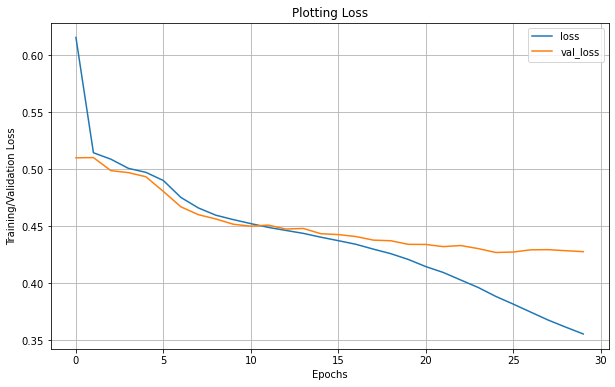

In [33]:
plt.figure(figsize=(10, 6))
plt.title("Plotting Loss")
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Loss")
plt.grid()
plt.show()

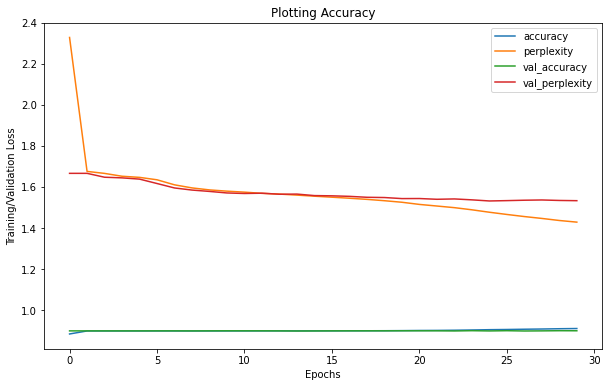

In [34]:
plt.figure(figsize=(10, 6))
plt.title("Plotting Accuracy")
plt.plot(history.history['accuracy'],label = 'accuracy')
plt.plot(history.history['perplexity'],label = 'perplexity')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.plot(history.history['val_perplexity'],label = 'val_perplexity')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Loss")
plt.show()

### Text Generation

In [35]:
encoder_model = tf.keras.models.Model(encoder_in_layer, state_h)

state_input_h = tf.keras.layers.Input(shape=(latent_dim * 2,))
inf_decoder_out, decoder_h = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_input_h)
inf_decoder_out = decoder_dense_1(inf_decoder_out)
inf_model = tf.keras.models.Model(inputs=[decoder_in_layer, state_input_h], 
                  outputs=[inf_decoder_out, decoder_h])

In [36]:
def tokenize_text(text):
    text = '<start> ' + text.lower() + ' <end>'
    text_tensor = tokenizer.texts_to_sequences([text])
    text_tensor = tf.keras.preprocessing.sequence.pad_sequences(text_tensor, maxlen=max_length_in, padding="post")
    return text_tensor

index_to_word = dict(map(reversed, tokenizer.word_index.items()))


### Generting Text with Beam search

In [47]:
def beam_search_2(input_seq, max_sequence_length,beam_width):
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    
    input_seq = tokenize_text(input_seq)
    initial_states = encoder_model.predict(input_seq,verbose=0)


    sequences = [[start_token, 0.0, initial_states]]

    while max(len([seq]) for seq, _, _ in sequences) < max_sequence_length:
        all_candidates = []
        for seq, score, states in sequences:
            if isinstance(seq, int):
                seq = [seq]
     
            output_probs, next_states = inf_model.predict([np.array([[seq[-1]]]), states],verbose=0)
            output_probs = output_probs[0, -1, :] 
    
            top_k_indices = np.argpartition(output_probs, -beam_width)[-beam_width:]
            for k in top_k_indices:
                candidate_seq = seq + [k]
                candidate_score = score - np.log(output_probs[k])
                # print(output_probs[k],"\n---------")
                all_candidates.append([candidate_seq, candidate_score, next_states])

        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = ordered[:beam_width]
        if sequences[0][0][-1] == end_token:
            break


    best_seq = sequences

    return best_seq

In [51]:
def get_text(text):
    text = text[1:-1]
    w = []
    for i in text:
        if i ==0 or i == 3:
            pass
        else:
            w.append(index_to_word[i])
    return " ".join(w)

def get_next_word(text,max_sequence_length,beam_width):
    op = beam_search_2(text,max_sequence_length,beam_width)
    for output in op:
        output = output[:-1]
        print(text +" "+(get_text(output[0])).strip(),"   ",output[1])

In [55]:
get_next_word("We will",max_sequence_length=2,beam_width=5)

We will <OOV>     0.3141701221643416
We will be     1.908257842070725
We will not     2.7186182737887066
We will have     3.4056062698618916
We will do     4.3316431045823265


### Greedy Search 

In [41]:
def decode_sequence(input_tensor):
    # Encode the input as state vectors.
    state = encoder_model.predict(input_tensor)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (max_length_out - 1):
        output_tokens, h = inf_model.predict([target_seq, state])
        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 3):
            break;

        curr_word = index_to_word[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1

    return decoded_sentence

In [43]:
decode_sequence(tokenize_text("can you come"))

1/1 [==============================] - 0s 19ms/step


' <OOV>'